In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [2]:
import matplotlib.pyplot as plt

# L3 - CNNs

Here is a link to an interactive guide to learn about CNNs: [Cnn-explainer](https://poloclub.github.io/cnn-explainer/)

## Digit Classification

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
print(f"Training images: {x_train.shape} of type: {x_train.dtype}")
print(f"Training labels: {y_train.shape} of type: {y_train.dtype}")

Training images: (60000, 28, 28) of type: uint8
Training labels: (60000,) of type: uint8


In [5]:
# resphape to add channel
x_train = x_train.reshape((*x_train.shape, 1))
x_test = x_test.reshape((*x_test.shape, 1))

In [6]:
print(f"Training images: {x_train.shape} of type: {x_train.dtype}")
print(f"Test images: {x_test.shape} of type: {x_test.dtype}")

Training images: (60000, 28, 28, 1) of type: uint8
Test images: (10000, 28, 28, 1) of type: uint8


### Base Model

In [7]:
def make_base_model(input_shape, classes):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = layers.Conv2D(8, 3, activation='relu')(inputs)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(16, 3, activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Flatten()(x)
    
    outputs = layers.Dense(classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

In [8]:
base_cnn = make_base_model(x_train.shape[1:], len(np.unique(y_train)))
base_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0     

In [9]:
base_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [10]:
base_cnn.fit(
    x=x_train, y=y_train,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 173s 46ms/step - loss: 0.6439 - accuracy: 0.9130
Epoch 2/3
3750/3750 [==============================] - 184s 49ms/step - loss: 0.0973 - accuracy: 0.9705
Epoch 3/3
3750/3750 [==============================] - 148s 40ms/step - loss: 0.0736 - accuracy: 0.9777


In [11]:
base_cnn.evaluate(
    x=x_test, y=y_test
)

313/313 [==============================] - 1s 1ms/step - loss: 0.0665 - accuracy: 0.9792


[0.06653501093387604, 0.979200005531311]

$\Rightarrow$ slightly better performance than our Multi-layer Perceptron with much fewer parameters ($235\,146$ vs. $5\,258$)

### Dilated Covolutions

In [12]:
def make_dilated_model(input_shape, classes, dilation_rate):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = layers.Conv2D(8, 3, activation='relu', dilation_rate=dilation_rate)(inputs)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(16, 3, activation='relu', dilation_rate=dilation_rate)(x)
    x = layers.MaxPool2D()(x)
    x = layers.Flatten()(x)
    
    outputs = layers.Dense(classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

In [13]:
dilated_cnn = make_dilated_model(x_train.shape[1:], len(np.unique(y_train)), 2)
dilated_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 16)          1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 256)               0   

In [14]:
dilated_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [15]:
dilated_cnn.fit(
    x=x_train, y=y_train,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 110s 29ms/step - loss: 1.1523 - accuracy: 0.8855
Epoch 2/3
3750/3750 [==============================] - 120s 32ms/step - loss: 0.1245 - accuracy: 0.9630
Epoch 3/3
3750/3750 [==============================] - 107s 28ms/step - loss: 0.0882 - accuracy: 0.9731


In [16]:
dilated_cnn.evaluate(
    x=x_test, y=y_test
)

313/313 [==============================] - 1s 1ms/step - loss: 0.0730 - accuracy: 0.9765


[0.07298260182142258, 0.9764999747276306]

$\Rightarrow$ somewhat worse performance, but note that we have even fewer parameters and that dilated convolutions are 
probably not a good fit for MNIST

### Separable Convolutions

In contrast to normal convolutions, which apply a convolutional kernel across all channels, depth-wise separable covolutions 
apply one filter per channel and then combine the channels in a second step into one output feature map by applying $1\times1$ 
convolutions. In order to obtain multiple output feature maps, multiple $1\times1$ convolutional kernels are applied.

In [17]:
def make_seperable_model(input_shape, classes):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Separable Convolutions don't make sense here, since we have only on input channel
    x = layers.Conv2D(8, 3, activation='relu')(inputs)
    x = layers.MaxPool2D()(x)
    x = layers.SeparableConv2D(16, 3, activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Flatten()(x)
    
    outputs = layers.Dense(classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

In [18]:
separable_cnn = make_seperable_model(x_train.shape[1:], len(np.unique(y_train)))
separable_cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 8)        0         
 2D)                                                             
                                                                 
 separable_conv2d (Separable  (None, 11, 11, 16)       216       
 Conv2D)                                                         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                           

Here, the number of paramters for the separable convolution is calculated as follows:

`kernel_size` $\cdot$ `in_channel_number` (convolutional kernel per channel) 

$+$ `in_channel_number` $\cdot$ `out_channel_number` (size of $1\times1$ convolutions times their number)

$+$ `out_channel_number` (biases for each $1\times1$ convolution)

In [19]:
separable_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [20]:
separable_cnn.fit(
    x=x_train, y=y_train,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 116s 31ms/step - loss: 0.5449 - accuracy: 0.9003
Epoch 2/3
3750/3750 [==============================] - 60s 16ms/step - loss: 0.1178 - accuracy: 0.9639
Epoch 3/3
3750/3750 [==============================] - 51s 14ms/step - loss: 0.0851 - accuracy: 0.9732


In [21]:
separable_cnn.evaluate(
    x=x_test, y=y_test
)

313/313 [==============================] - 1s 1ms/step - loss: 0.0835 - accuracy: 0.9740


[0.08348453044891357, 0.9739999771118164]

## Denoising MNIST

In [ ]:
# prepare target data
x_train_target = x_train.copy()
x_test_target = x_test.copy()

# binarize
x_train_target[x_train_target < 125] = 0
x_train_target[x_train_target >= 125] = 1
x_test_target[x_test_target < 125] = 0
x_test_target[x_test_target >= 125] = 1

: 

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((x_train_target[i] * 255).astype('uint8'))
    plt.axis('off')
plt.show()

In [ ]:
# prepare input data
x_train_input = x_train.copy()
x_test_input = x_test.copy()

# add salt and pepper noise
rng = np.random.default_rng(42)
train_mask = rng.binomial(1, 0.4, x_train_input.shape)
train_noise = rng.binomial(1, 0.5, x_train_input.shape) * 255
test_mask = rng.binomial(1, 0.4, x_test_input.shape)
test_noise = rng.binomial(1, 0.5, x_test_input.shape) * 255

x_train_input = x_train_input * (1-train_mask) + train_noise * train_mask
x_test_input = x_test_input * (1-test_mask) + test_noise * test_mask


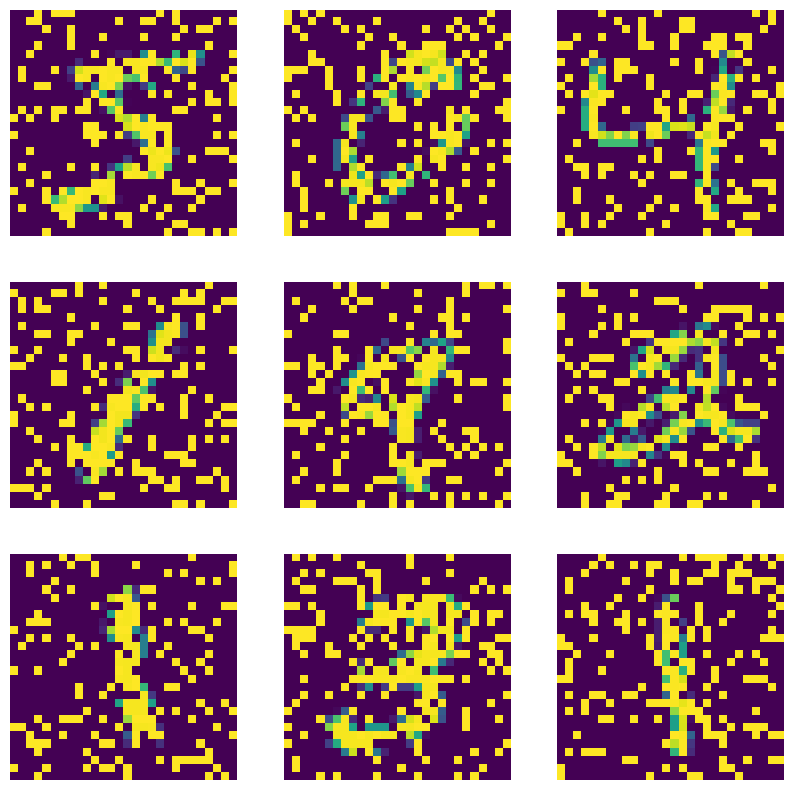

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((x_train_input[i]).astype('uint8'))
    plt.axis('off')
plt.show()

In [ ]:
def make_denoiser_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = layers.Rescaling(1.0 / 255)(inputs)
    
    # encoder path
    conv1 = layers.Conv2D(8, 3, activation='relu', padding='same')(x)
    x = layers.MaxPool2D()(conv1)
    conv2 = layers.SeparableConv2D(16, 3, activation='relu', padding='same')(x)
    x = layers.MaxPool2D()(conv2)
    
    # decoder path
    x = layers.Conv2DTranspose(16, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.concatenate([x, conv2])
    
    x = layers.Conv2DTranspose(8, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.concatenate([x, conv1])
    
    outputs = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    
    return tf.keras.Model(inputs, outputs)

In [ ]:
denoiser_cnn = make_denoiser_model(x_train_input.shape[1:])
denoiser_cnn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 28, 28, 1)    0           ['input_4[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 28, 28, 8)    80          ['rescaling[0][0]']              
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 14, 14, 8)   0           ['conv2d_5[0][0]']               
                                                                                            

In [ ]:
denoiser_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
)

In [ ]:
denoiser_cnn.fit(
    x=x_train_input, y=x_train_target,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 28s 7ms/step - loss: 0.1155 - accuracy: 0.9511 - mean_io_u: 0.4333
Epoch 2/3
3750/3750 [==============================] - 28s 7ms/step - loss: 0.0931 - accuracy: 0.9602 - mean_io_u: 0.4333
Epoch 3/3
3750/3750 [==============================] - 28s 7ms/step - loss: 0.0852 - accuracy: 0.9642 - mean_io_u: 0.4333


In [ ]:
denoiser_cnn.evaluate(
    x=x_test_input, y=x_test_target
)

313/313 [==============================] - 2s 6ms/step - loss: 0.0792 - accuracy: 0.9673 - mean_io_u: 0.4324


[0.07919643819332123, 0.9673327803611755, 0.43236982822418213]

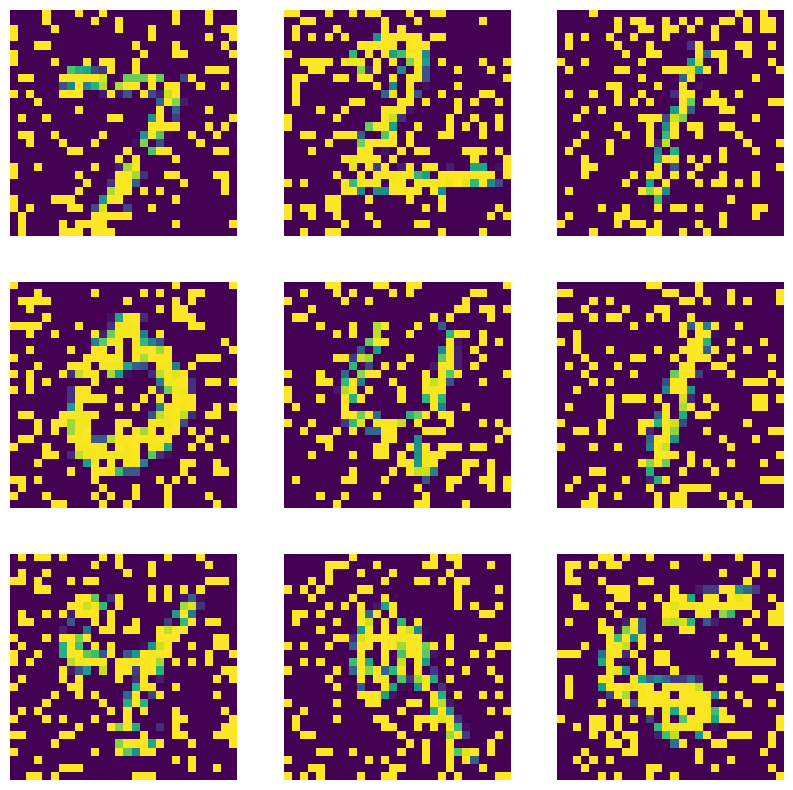

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_test_input[i])
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 19ms/step


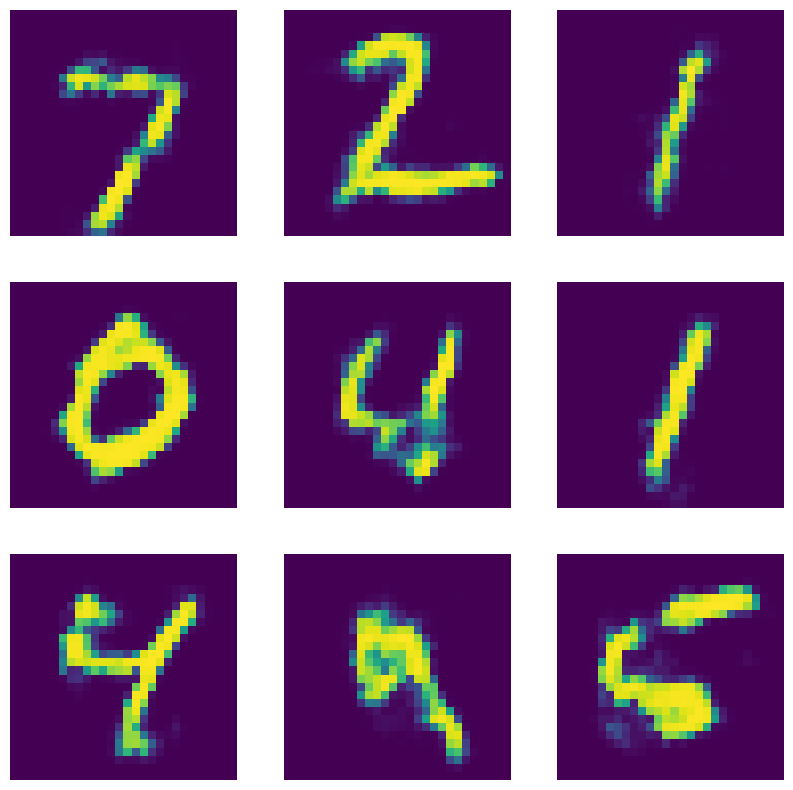

In [ ]:
plt.figure(figsize=(10, 10))
imgs = []
for i in range(9):
    img = denoiser_cnn.predict(x_test_input[i].reshape(1, *x_test_input.shape[1:]))
    imgs.append((img.reshape(x_test_input.shape[1:-1]) * 255).astype('uint8'))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.show()

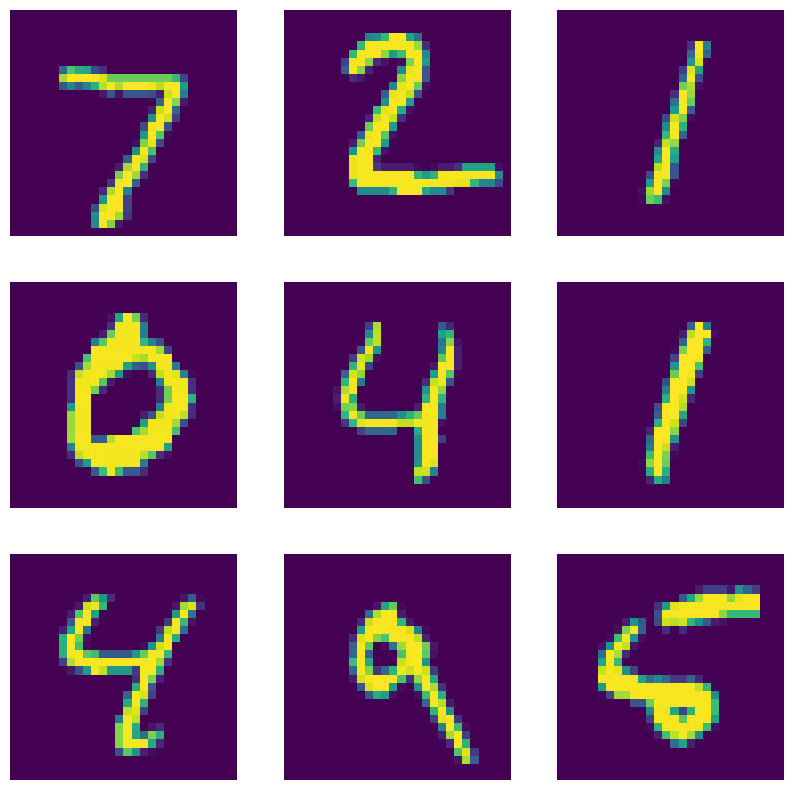

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[i])
    plt.axis('off')
plt.show()

In [ ]:
denoiser_cnn.save('noise_.4.h5')

In [ ]:
# prepare larger input
ds, height, width, channels = x_test_input.shape
large_image = np.zeros((1, height * 3, width * 3, 1))
for i in range(9):
    y, x = divmod(i, 3)
    large_image[0, width*x:width*x+width, height*y:height*y+height] = x_test_input[i]

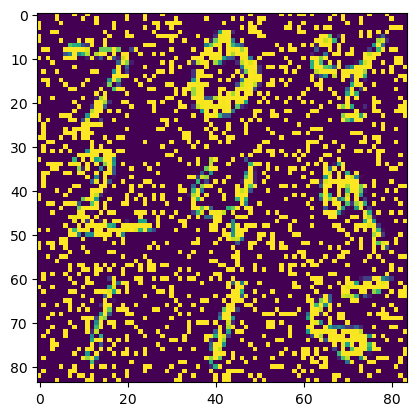

In [ ]:
plt.imshow(large_image[0, :, :, 0])
plt.show()

In [ ]:
denoiser_cnn = tf.keras.models.load_model('noise_.4.h5')

In [ ]:
new_model = make_denoiser_model(large_image.shape[1:])
# iterate over all the layers that we want to get weights from
weights = [layer.get_weights() for layer in denoiser_cnn.layers[1:]]
for layer, weight in zip(new_model.layers[1:], weights):
    layer.set_weights(weight)

In [ ]:
new_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 84, 84, 1)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 84, 84, 1)    0           ['input_5[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 84, 84, 8)    80          ['rescaling_1[0][0]']            
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 42, 42, 8)   0           ['conv2d_7[0][0]']               
                                                                                            

In [ ]:
denoised_img = new_model.predict(large_image)

1/1 [==============================] - 0s 98ms/step


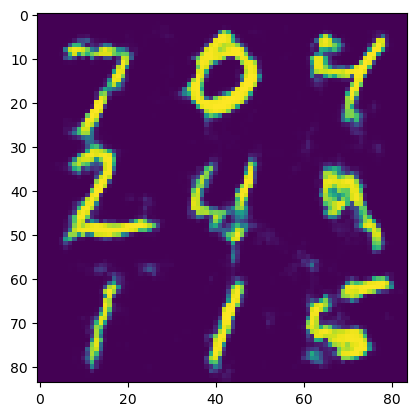

In [ ]:
plt.imshow(denoised_img[0, :, :, 0])
plt.show()